In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hindi-scipt/NotoSansDevanagari-VariableFont_wdth,wght.ttf
/kaggle/input/hindi-scipt/README.txt
/kaggle/input/hindi-scipt/OFL.txt
/kaggle/input/hindi-scipt/static/NotoSansDevanagari_ExtraCondensed-ExtraBold.ttf
/kaggle/input/hindi-scipt/static/NotoSansDevanagari_SemiCondensed-Medium.ttf
/kaggle/input/hindi-scipt/static/NotoSansDevanagari_ExtraCondensed-Bold.ttf
/kaggle/input/hindi-scipt/static/NotoSansDevanagari_SemiCondensed-Black.ttf
/kaggle/input/hindi-scipt/static/NotoSansDevanagari_Condensed-Black.ttf
/kaggle/input/hindi-scipt/static/NotoSansDevanagari-Bold.ttf
/kaggle/input/hindi-scipt/static/NotoSansDevanagari-Regular.ttf
/kaggle/input/hindi-scipt/static/NotoSansDevanagari_ExtraCondensed-Light.ttf
/kaggle/input/hindi-scipt/static/NotoSansDevanagari_ExtraCondensed-Black.ttf
/kaggle/input/hindi-scipt/static/NotoSansDevanagari_SemiCondensed-Thin.ttf
/kaggle/input/hindi-scipt/static/NotoSansDevanagari-ExtraLight.ttf
/kaggle/input/hindi-scipt/static/NotoSansDevanagari_Co

# Step 1 : Setting up the wandb

In [9]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

In [10]:
import wandb
wandb.login(key=secret_value_0)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Step 2 : importing the important libraries

In [11]:
import os, random, time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import wandb
from pathlib import Path
from IPython.display import HTML, display
import matplotlib.font_manager as fm
import pathlib
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from math import ceil

# Step 3 : set the seed for reproducibility and setting up the device

In [12]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 4 : Loading the dataset ( Dakshina dataset)

In [13]:
def load_dakshina_pairs(path):    
    df = (
        pd.read_csv(path,sep="\t",names=["native", "latin", "count"],
            dtype={"native": str, "latin": str, "count": str}  # force strings
        )
        .dropna(subset=["native", "latin"])       # <-- NEW: keep only complete rows
    )

    # strip any stray whitespace
    df["native"] = df["native"].str.strip()
    df["latin"]  = df["latin"].str.strip()

    # remove empty strings (after strip)
    df = df[(df["native"] != "") & (df["latin"] != "")]
    return list(zip(df["latin"], df["native"]))


# Step 5 : The build_vocab function constructs character-level vocabularies for source and target scripts.
# The TransliterationDataset prepares source-target sequence pairs.

In [14]:
# Building vocab
def build_vocab(pairs, specials=None):
    specials = specials or ["<pad>", "<sos>", "<eos>", "<unk>"]
    latin  = [src for src, _ in pairs if isinstance(src, str)]
    deva   = [tgt for _, tgt in pairs if isinstance(tgt, str)]
    input_chars  = sorted(set("".join(latin)))
    target_chars = sorted(set("".join(deva)))
    return specials + input_chars, specials + target_chars


class TransliterationDataset(Dataset):
    def __init__(self, pairs, in2idx, out2idx, max_in, max_out):
        self.pairs, self.in2idx, self.out2idx = pairs, in2idx, out2idx
        self.max_in, self.max_out = max_in, max_out
        self.pad_i, self.pad_o = in2idx["<pad>"], out2idx["<pad>"]

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        latin, deva = self.pairs[idx]

        src = [self.in2idx["<sos>"]]  + [self.in2idx.get(c, self.in2idx["<unk>"])  for c in latin] + [self.in2idx["<eos>"]]
        tgt = [self.out2idx["<sos>"]] + [self.out2idx.get(c, self.out2idx["<unk>"]) for c in deva]  + [self.out2idx["<eos>"]]

        # truncate then pad
        src = src[:self.max_in]  + [self.pad_i] * (self.max_in  - len(src))
        tgt = tgt[:self.max_out] + [self.pad_o] * (self.max_out - len(tgt))

        return torch.tensor(src), torch.tensor(tgt)

# Step 6 : Bahdanau Attention

In [24]:
class BahdanauAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        
        # linear projections for encoder outputs and decoder hidden
        self.W_enc = nn.Linear(enc_dim, dec_dim, bias=False)
        self.W_dec = nn.Linear(dec_dim, dec_dim, bias=False)
        self.v     = nn.Linear(dec_dim, 1, bias=False)   # scoring vector


    def forward(self, dec_hidden, enc_outputs, mask):
        # dec_hidden: [B, dec_dim]   enc_outputs: [B, S, enc_dim]  mask: [B, S]
        score = self.v(torch.tanh(self.W_enc(enc_outputs) + self.W_dec(dec_hidden).unsqueeze(1))).squeeze(-1)
        score.masked_fill_(mask == 0, -1e9)
        attn = torch.softmax(score, dim=1)                       # [B, S]
        ctx  = torch.bmm(attn.unsqueeze(1), enc_outputs).squeeze(1)  # [B, enc_dim]
        return ctx, attn                  #  context, weights

# Step 7 :  Seq2Seq with Bahdanau Attention

In [16]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, in_vocab, out_vocab, emb_dim, hid_dim,rnn_type="LSTM", dropout=0.3, bidir=False, pad_idx=0,enc_layers=1, dec_layers=1):
        super().__init__()
        rnn_cls = getattr(nn, rnn_type)
        self.rnn_type, self.pad_idx, self.bidir = rnn_type, pad_idx, bidir
        self.dir_mult = 2 if bidir else 1
        self.dec_layers = dec_layers

        # Embeddings
        self.src_emb = nn.Embedding(in_vocab, emb_dim, padding_idx=pad_idx)
        self.tgt_emb = nn.Embedding(out_vocab, emb_dim, padding_idx=pad_idx)

        # Encoder
        self.encoder = rnn_cls(emb_dim, hid_dim, enc_layers, batch_first=True, bidirectional=bidir, dropout=dropout if enc_layers > 1 else 0)

        # Bridge for bidirectional 
        if bidir or enc_layers != dec_layers:
            self.bridge = nn.Linear(hid_dim * self.dir_mult, hid_dim)

        # Attention
        self.attn = BahdanauAttention(hid_dim * self.dir_mult, hid_dim)

        # Decoder (input = [emb | ctx])
        self.decoder = rnn_cls(emb_dim + hid_dim * self.dir_mult,hid_dim, dec_layers, batch_first=True,dropout=dropout if dec_layers > 1 else 0)

        self.fc_out = nn.Linear(hid_dim, out_vocab)
        self.dropout = nn.Dropout(dropout)

    # ----- helper to initialise decoder hidden -------------
    def _init_dec_state(self, enc_hidden):
        if self.rnn_type == "LSTM":
            h, c = enc_hidden
        else:
            h = enc_hidden

        if self.bidir:
            if self.rnn_type == "LSTM":
                h = torch.cat([h[-2], h[-1]], dim=1)
                c = torch.cat([c[-2], c[-1]], dim=1)
                h = self.bridge(h).unsqueeze(0)
                c = self.bridge(c).unsqueeze(0)
                h = h.repeat(self.dec_layers, 1, 1)
                c = c.repeat(self.dec_layers, 1, 1)
                return (h, c)
            else:
                h = torch.cat([h[-2], h[-1]], dim=1)
                h = self.bridge(h).unsqueeze(0)
                h = h.repeat(self.dec_layers, 1, 1)
                return h
        else:
            # same #layers; copy last layer out
            if self.rnn_type == "LSTM":
                h = h[-1:].repeat(self.dec_layers,1,1)
                c = c[-1:].repeat(self.dec_layers,1,1)
                return (h,c)
            else:
                h = h[-1:].repeat(self.dec_layers,1,1)
                return h


    def forward(self, src, tgt, teacher_forcing=0.5):
        B, S = src.size()
        _, T = tgt.size()
        mask = (src != self.pad_idx)                # [B,S]

        # ---- encode ----
        enc_outs, enc_hidden = self.encoder(self.dropout(self.src_emb(src)))
        dec_hidden = self._init_dec_state(enc_hidden)

        # ---- decode ----
        outputs = torch.zeros(B, T, self.fc_out.out_features, device=src.device)
        input_t = tgt[:, 0]                         # <sos>

        for t in range(1, T):
            emb_t = self.dropout(self.tgt_emb(input_t)).unsqueeze(1)  # [B,1,E]
            # last-layer hidden for attention
            dec_last = dec_hidden[0][-1] if self.rnn_type=="LSTM" else dec_hidden[-1]  # [B, H]
            ctx, _   = self.attn(dec_last, enc_outs, mask)

            rnn_inp  = torch.cat([emb_t, ctx.unsqueeze(1)], dim=2)    # [B,1,E+H]
            dec_out, dec_hidden = self.decoder(rnn_inp, dec_hidden)
            pred = self.fc_out(dec_out.squeeze(1))                    # [B, V]
            outputs[:, t] = pred

            teacher = torch.rand(1).item() < teacher_forcing
            input_t = tgt[:, t] if teacher else pred.argmax(1)

        return outputs   # logits


# Step 8 : Evaluate the model

In [17]:
def evaluate(model, loader, idx2char, eos_idx, pad_idx):
    model.eval()
    corr_chars = tot_chars = corr_words = tot_words = 0
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            logits = model(src, tgt, teacher_forcing=0)          # no TF in eval
            pred  = logits.argmax(-1)[:,1:]      # drop <sos> column
            gold  = tgt[:,1:]

            mask = gold != pad_idx
            corr_chars += (pred == gold).masked_select(mask).sum().item()
            tot_chars  += mask.sum().item()

            # word-level exact match
            for p, g in zip(pred, gold):
                p = p.tolist()
                g = g.tolist()
                if eos_idx in p: p = p[:p.index(eos_idx)]
                if eos_idx in g: g = g[:g.index(eos_idx)]
                if "".join(idx2char[i] for i in p) == "".join(idx2char[i] for i in g):
                    corr_words += 1
                tot_words += 1
    return corr_chars/tot_chars, corr_words/tot_words

# Step 9 : Wandb training function

In [19]:
def train_wandb(config=None):
    with wandb.init(config=config):
        cfg = wandb.config

        # data paths 
        root = "/kaggle/input/snehal"
        train_pairs = load_dakshina_pairs(os.path.join(root,"hi.translit.sampled.train.tsv"))
        dev_pairs   = load_dakshina_pairs(os.path.join(root,"hi.translit.sampled.dev.tsv"))

        # build vocabs
        in_vocab, out_vocab = build_vocab(train_pairs)
        in2idx  = {c:i for i,c in enumerate(in_vocab)}
        out2idx = {c:i for i,c in enumerate(out_vocab)}
        idx2out = {i:c for c,i in out2idx.items()}
        PAD, EOS = out2idx["<pad>"], out2idx["<eos>"]

        max_in  = max(len(p[0]) for p in train_pairs)+2
        max_out = max(len(p[1]) for p in train_pairs)+2

        train_ds = TransliterationDataset(train_pairs,in2idx,out2idx,max_in,max_out)
        dev_ds   = TransliterationDataset(dev_pairs,  in2idx,out2idx,max_in,max_out)
        train_ld = DataLoader(train_ds,batch_size=cfg.batch_size,shuffle=True)
        dev_ld   = DataLoader(dev_ds,  batch_size=cfg.batch_size)

        # --- model ---
        # model = Seq2SeqAttention(
        #     in_vocab=len(in_vocab),
        #     out_vocab=len(out_vocab),
        #     emb_dim=cfg.emb_dim,
        #     hid_dim=cfg.hid_dim,
        #     rnn_type=cfg.rnn_type,
        #     dropout=cfg.dropout,
        #     bidir=cfg.bidir,
        #     pad_idx=PAD,
        #     enc_layers=1,
        #     dec_layers=1
        # ).to(device)


        # build model
        model = Seq2SeqAttention(in_vocab=len(in_vocab),out_vocab=len(out_vocab),emb_dim=cfg.emb_dim,hid_dim=cfg.hid_dim,rnn_type=cfg.cell_type,dropout=cfg.dropout,bidir=cfg.bidir,pad_idx=PAD,enc_layers=1,dec_layers=1).to(device)

        # --- optimiser / loss ---
        opt = optim.Adam(model.parameters(), lr=cfg.lr)
        criterion = nn.CrossEntropyLoss(ignore_index=PAD)

        # --- training loop ---
        for epoch in range(1, cfg.epochs+1):
            model.train()
            epoch_loss = 0
            for src, tgt in train_ld:
                src, tgt = src.to(device), tgt.to(device)
                logits = model(src, tgt, teacher_forcing=cfg.tf_ratio)
                loss   = criterion(logits[:,1:].reshape(-1, logits.size(-1)),
                                   tgt[:,1:].reshape(-1))
                opt.zero_grad(); loss.backward(); opt.step()
                epoch_loss += loss.item()

            char_acc, word_acc = evaluate(model, dev_ld, idx2out, EOS, PAD)
            wandb.log({
                "epoch": epoch,
                "train_loss": epoch_loss/len(train_ld),
                "val_char_acc": char_acc,
                "val_word_acc": word_acc
            })





# Step 10 : Sweep Configuration & Launch



In [ ]:

sweep_cfg = {
    "method": "bayes",
    "metric": {"name": "val_char_acc", "goal": "maximize"},
    "parameters": {
        "batch_size": {"values": [32,64]},
        "emb_dim":    {"values": [16,32, 64, 128, 256]},
        "hid_dim":    {"values": [16,32, 64, 128, 256]},
        "cell_type":  {"values": ["RNN", "GRU", "LSTM"]},
        "beam_size":  {"values": [1, 3, 5]},
        "dropout":    {"values": [0.2, 0.3]},
        "bidir":      {"values": [True, False]},
        "lr":         {"values": [1e-3, 5e-4]},
        "tf_ratio":   {"values": [1]},
        "epochs":     {"value": 10}
    }
}

sweep_id = wandb.sweep(sweep_cfg, project="dakshina-translit-hi")
wandb.agent(sweep_id, function=train_wandb, count=57,project="dakshina-translit-hi")


Create sweep with ID: i6h8vkm4
Sweep URL: https://wandb.ai/snehalma23m020-iit-madras/dakshina-translit-hi/sweeps/i6h8vkm4


wandb: Agent Starting Run: ddfchk4s with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	epochs: 10
wandb: 	hid_dim: 128
wandb: 	lr: 0.0005
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_acc,▁▄▆▆▇▇▇███
val_word_acc,▁▄▆▆▇▇▇███
epoch,10
train_loss,0.34979
val_char_acc,0.70804
val_word_acc,0.38022


wandb: Agent Starting Run: 7znd2k8v with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 1
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	epochs: 10
wandb: 	hid_dim: 32
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▂▂▂▁▁▁▁▁
val_char_acc,▁▆▇▇▇█████
val_word_acc,▁▄▅▆▇▇▇███
epoch,10
train_loss,0.61287
val_char_acc,0.65883
val_word_acc,0.29578


wandb: Agent Starting Run: ngxrpi3e with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	epochs: 10
wandb: 	hid_dim: 64
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_acc,▁▄▄▆▇▇▇███
val_word_acc,▁▄▅▆▇▇▇███
epoch,10
train_loss,0.44357
val_char_acc,0.70735
val_word_acc,0.37196


wandb: Agent Starting Run: jg4qmfup with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	emb_dim: 64
wandb: 	epochs: 10
wandb: 	hid_dim: 16
wandb: 	lr: 0.0005
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▆▅▄▄▃▂▁▁
val_char_acc,▁▁▁▂▂▄▅▆▇█
val_word_acc,▁▁▁▁▁▂▃▄▅█
epoch,10
train_loss,1.26324
val_char_acc,0.51211
val_word_acc,0.10601


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oy66ss0h with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: RNN
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_acc,▁▄▄▅▆▄▆▇▆█
val_word_acc,▁▅▅▆▇▆▇▇▇█
epoch,10
train_loss,0.34132
val_char_acc,0.70732
val_word_acc,0.37058


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qmdzeebt with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▂▁▁▁
val_char_acc,▁▅▅▆█▇█▇█▇
val_word_acc,▁▅▅▇█▇█▇▇▇
epoch,10
train_loss,0.15081
val_char_acc,0.74264
val_word_acc,0.42588


wandb: Agent Starting Run: wkgidt54 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.0005
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_acc,▁▅▆▇▇▇▇▇▇█
val_word_acc,▁▅▆▇▇▇█▇██
epoch,10
train_loss,0.27518
val_char_acc,0.73638
val_word_acc,0.41625


wandb: Agent Starting Run: 6oy7vkp1 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_char_acc,▁▃▅▆▇▇▇▇██
val_word_acc,▁▄▅▆▇▇▇▇▇█
epoch,10
train_loss,0.22551
val_char_acc,0.73747
val_word_acc,0.41992


wandb: Agent Starting Run: 7j5g6s2f with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.0005
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_acc,▁▃▅▆▇▇▇▇██
val_word_acc,▁▄▅▆▆▇▇▇██
epoch,10
train_loss,0.30898
val_char_acc,0.73908
val_word_acc,0.4229


wandb: Agent Starting Run: 0zmzrg1r with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.0005
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▃▅▅▆▇▇███
val_word_acc,▁▃▅▆▆▇▇███
epoch,10
train_loss,0.25565
val_char_acc,0.75449
val_word_acc,0.44539


wandb: Agent Starting Run: cvujn8fn with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: RNN
wandb: 	dropout: 0.3
wandb: 	emb_dim: 16
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.0005
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_char_acc,▁▄▅▆▇▇▇███
val_word_acc,▁▄▅▆▇▇████
epoch,10
train_loss,0.52796
val_char_acc,0.70158
val_word_acc,0.352


wandb: Agent Starting Run: h71p3f4f with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▄▄▆▆▇▇▇▇█
val_word_acc,▁▄▅▆▆█▇▇▇█
epoch,10
train_loss,0.20207
val_char_acc,0.76184
val_word_acc,0.4548


wandb: Agent Starting Run: 31285cs4 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 16
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_char_acc,▁▅▆▆▇▇▇███
val_word_acc,▁▅▆▇▇▇▇███
epoch,10
train_loss,0.31636
val_char_acc,0.72671
val_word_acc,0.39422


wandb: Agent Starting Run: urcrdfq4 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▃▅▇██▇███
val_word_acc,▁▄▆▇▇▇▇███
epoch,10
train_loss,0.19697
val_char_acc,0.74944
val_word_acc,0.44355


wandb: Agent Starting Run: jv69bgxm with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▄▅▆▇███▇▇
val_word_acc,▁▄▆▇▇▇██▇▇
epoch,10
train_loss,0.2244
val_char_acc,0.72374
val_word_acc,0.39514


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: drfn92f6 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.0005
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▄▆▆▆▇▇███
val_word_acc,▁▅▆▆▆▇▇▇██
epoch,10
train_loss,0.25531
val_char_acc,0.73783
val_word_acc,0.42106


wandb: Agent Starting Run: kxtcgk3d with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	emb_dim: 16
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_char_acc,▁▃▅▆▇█████
val_word_acc,▁▄▅▆▇▇█▇██
epoch,10
train_loss,0.31458
val_char_acc,0.73493
val_word_acc,0.41923


wandb: Agent Starting Run: veo9ior4 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: RNN
wandb: 	dropout: 0.3
wandb: 	emb_dim: 16
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.0005
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_char_acc,▁▄▅▆▆▆▇▇██
val_word_acc,▁▄▅▆▇▇▇▇██
epoch,10
train_loss,0.46811
val_char_acc,0.70135
val_word_acc,0.35727


wandb: Agent Starting Run: yvs121lo with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▅▆▇▇▇█▇██
val_word_acc,▁▅▆▇▇▇████
epoch,10
train_loss,0.17626
val_char_acc,0.74944
val_word_acc,0.44355


wandb: Agent Starting Run: vf0ylmf1 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▃▅▅▇▇█▆▇█
val_word_acc,▁▃▅▅▇▇█▇▇█
epoch,10
train_loss,0.21488
val_char_acc,0.74357
val_word_acc,0.42451


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 85195mce with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	emb_dim: 32
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▄▅▆▇▆██▇█
val_word_acc,▁▄▆▇▇▆████
epoch,10
train_loss,0.24368
val_char_acc,0.75722
val_word_acc,0.44562


wandb: Agent Starting Run: fvkr0mpo with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.0005
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_char_acc,▁▅▆▆▇█████
val_word_acc,▁▅▆▆▇█████
epoch,10
train_loss,0.21263
val_char_acc,0.74505
val_word_acc,0.43483


wandb: Agent Starting Run: sdjea2yi with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▃▄▇▇▇████
val_word_acc,▁▄▄▇▇▇▇▇▇█
epoch,10
train_loss,0.18681
val_char_acc,0.75386
val_word_acc,0.44608


wandb: Agent Starting Run: g9i7yiav with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▄▅▆▇▆▇███
val_word_acc,▁▄▅▆▇▆▇███
epoch,10
train_loss,0.22417
val_char_acc,0.73489
val_word_acc,0.41923


wandb: Agent Starting Run: hpam26wv with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▅▆▇▇██▇▇▇
val_word_acc,▁▅▇█▇▇█▆█▇
epoch,10
train_loss,0.19098
val_char_acc,0.74156
val_word_acc,0.4128


wandb: Agent Starting Run: 0j9kvshh with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▂▁▁▁
val_char_acc,▁▄▆▇▇███▇█
val_word_acc,▁▅▆▇███▇█▇
epoch,10
train_loss,0.1633
val_char_acc,0.74782
val_word_acc,0.42244


wandb: Agent Starting Run: 5t6p3998 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_char_acc,▁▄▅▇▇▇████
val_word_acc,▁▄▅▇▇▇█▇▇█
epoch,10
train_loss,0.16752
val_char_acc,0.75237
val_word_acc,0.44011


wandb: Agent Starting Run: xgida21r with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_char_acc,▁▄▅▇█▇████
val_word_acc,▁▄▅▆█▇██▇▆
epoch,10
train_loss,0.15086
val_char_acc,0.7499
val_word_acc,0.42198


wandb: Agent Starting Run: 796e214o with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▄▅▆▆▇████
val_word_acc,▁▄▅▅▆▇████
epoch,10
train_loss,0.19771
val_char_acc,0.73638
val_word_acc,0.41923


wandb: Agent Starting Run: bsolyxeo with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 1
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▃▆▅▇▇▇▇▇█
val_word_acc,▁▄▆▆▇▇█▇▇█
epoch,10
train_loss,0.22307
val_char_acc,0.73608
val_word_acc,0.41762


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1u528hj6 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	bidir: False
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▃▅▆▆▆▇▇██
val_word_acc,▁▃▅▅▆▆▇▇██
epoch,10
train_loss,0.22488
val_char_acc,0.73516
val_word_acc,0.41556


wandb: Agent Starting Run: lkaj9bzx with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▅▅▆▇█▇▇██
val_word_acc,▁▅▅▆▇█▇▇██
epoch,10
train_loss,0.1963
val_char_acc,0.74182
val_word_acc,0.41762


wandb: Agent Starting Run: 8xheidf7 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▄▆▇▆▆▇▇██
val_word_acc,▁▅▆▆▆▅▇▇▇█
epoch,10
train_loss,0.1972
val_char_acc,0.73938
val_word_acc,0.42106


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dsern9h8 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▃▄▆▆▇█▇██
val_word_acc,▁▃▄▆▇██▇█▇
epoch,10
train_loss,0.21862
val_char_acc,0.73674
val_word_acc,0.40776


wandb: Agent Starting Run: 5khlx0i2 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_char_acc,▁▄▆▆▇▇▇███
val_word_acc,▁▄▆▇▇█████
epoch,10
train_loss,0.23363
val_char_acc,0.73295
val_word_acc,0.4128


wandb: Agent Starting Run: i15lltfm with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_char_acc,▁▄▆▆▇▇▇█▇█
val_word_acc,▁▅▅▇██▆█▇█
epoch,10
train_loss,0.18073
val_char_acc,0.74439
val_word_acc,0.42703


wandb: Agent Starting Run: 4w31nhin with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▄▆▇▇▇████
val_word_acc,▁▃▆▇▇▇██▇▇
epoch,10
train_loss,0.16909
val_char_acc,0.74951
val_word_acc,0.43208


wandb: Agent Starting Run: 54iq48bh with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▃▅▅▅▇▇▇██
val_word_acc,▁▄▅▄▆▇▇▇██
epoch,10
train_loss,0.1949
val_char_acc,0.74413
val_word_acc,0.42336


wandb: Agent Starting Run: 5hb4u3ys with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▄▆▇██████
val_word_acc,▁▄▅▇██████
epoch,10
train_loss,0.18172
val_char_acc,0.75033
val_word_acc,0.44034


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bt63xmer with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 64
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▅▆▆▆▇██▇█
val_word_acc,▁▅▆▆▆█████
epoch,10
train_loss,0.22795
val_char_acc,0.73526
val_word_acc,0.4112


wandb: Agent Starting Run: aqraol75 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 1
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_char_acc,▁▃▆▇█▇▇██▆
val_word_acc,▁▄▆▇▇▇▇█▇▆
epoch,10
train_loss,0.16592
val_char_acc,0.73588
val_word_acc,0.41579


wandb: Agent Starting Run: plliepi7 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


In [ ]:
# ==============================================================
# 6) Sweep Configuration & Launch
# ==============================================================

sweep_cfg = {
    "method": "bayes",
    "metric": {"name": "val_char_acc", "goal": "maximize"},
    "parameters": {
        "batch_size": {"values": [32,64]},
        "emb_dim":    {"values": [16,32, 64, 128, 256]},
        "hid_dim":    {"values": [16,32, 64, 128, 256]},
        "cell_type":  {"values": ["RNN", "GRU", "LSTM"]},
        "beam_size":  {"values": [1, 3, 5]},
        "dropout":    {"values": [0.2, 0.3]},
        "bidir":      {"values": [True, False]},
        "lr":         {"values": [1e-3, 5e-4]},
        "tf_ratio":   {"values": [1]},
        "epochs":     {"value": 10}
    }
}

#sweep_id = wandb.sweep(sweep_cfg, project="dakshina-translit-hi")
sweep_id = 'i6h8vkm4'
wandb.agent(sweep_id, function=train_wandb, count=100,
            project="dakshina-translit-hi",entity='snehalma23m020-iit-madras')
#View sweep at https://wandb.ai/snehalma23m020-iit-madras/dakshina-translit-hi/sweeps/i6h8vkm4

wandb: Agent Starting Run: r6h32lze with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▅▅▅▅▇▇▆▇█
val_word_acc,▁▅▅▆▆▇█▇▇█
epoch,10
train_loss,0.22082
val_char_acc,0.74017
val_word_acc,0.41349


wandb: Agent Starting Run: xxijv08e with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▂▁▁▁
val_char_acc,▁▃▅▆▇█▇██▇
val_word_acc,▁▄▅▆▆████▇
epoch,10
train_loss,0.16531
val_char_acc,0.74875
val_word_acc,0.43162


wandb: Agent Starting Run: r9t31ejt with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▄▅▆██▇███
val_word_acc,▁▄▅▆█▇▇██▇
epoch,10
train_loss,0.18163
val_char_acc,0.74842
val_word_acc,0.43254


wandb: Agent Starting Run: emmjgc4v with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▄▅▆▇▇▇███
val_word_acc,▁▄▅▆▇████▇
epoch,10
train_loss,0.21566
val_char_acc,0.73519
val_word_acc,0.40959


wandb: Agent Starting Run: 225mxfvf with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▃▅▆▆▆▆█▇▇
val_word_acc,▁▄▅▆▆▆▇███
epoch,10
train_loss,0.2255
val_char_acc,0.73314
val_word_acc,0.40776


wandb: Agent Starting Run: egmon2br with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▄▆▇▆██▇██
val_word_acc,▁▄▆▇▆█▇▇██
epoch,10
train_loss,0.17014
val_char_acc,0.74716
val_word_acc,0.43575


wandb: Agent Starting Run: 58gesi0t with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_char_acc,▁▅▆▆▇▇▇▇██
val_word_acc,▁▅▆▆▇▇█▇██
epoch,10
train_loss,0.21741
val_char_acc,0.7378
val_word_acc,0.42267


wandb: Agent Starting Run: 0za4rmi4 with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 1
wandb: 	bidir: False
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_char_acc,▁▄▆▇▆▅▇▆█▇
val_word_acc,▁▄▆█▆▆▇▆█▇
epoch,10
train_loss,0.25303
val_char_acc,0.72249
val_word_acc,0.39009


wandb: Agent Starting Run: xwqwthel with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	bidir: False
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	emb_dim: 128
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_char_acc,▁▄▅▆▆▇██▇█
val_word_acc,▁▄▆▆▆▇██▇█
epoch,10
train_loss,0.23198
val_char_acc,0.74126
val_word_acc,0.42152


wandb: Agent Starting Run: 7p78vvxg with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 3
wandb: 	bidir: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	emb_dim: 256
wandb: 	epochs: 10
wandb: 	hid_dim: 256
wandb: 	lr: 0.001
wandb: 	tf_ratio: 1


# Step 11 : The best hyperparameters obtained are 

# batch_size = 32,
# beam_size  = 5,
# bidir      = True,
# cell_type  = "LSTM",         
# dropout    = 0.3,
# emb_dim    = 32,
# epochs     = 10,
# hid_dim    = 256,
# lr         = 0.001,
# tf_ratio   = 1.0, 

# Step 12 : Train single-layer bidirectional Seq2Seq model with Bahdanau attention 

In [20]:
# best hyper-parameters found by sweep
BEST_CFG = dict(
    batch_size = 32,
    beam_size  = 5,
    bidir      = True,
    cell_type  = "LSTM",
    dropout    = 0.3,
    emb_dim    = 32,
    epochs     = 10,
    hid_dim    = 256,
    lr         = 1e-3,
    tf_ratio   = 1.0,     # teacher forcing
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)

In [21]:
def load_pairs(path):
    df = (pd.read_csv(path, sep="\t", names=["native","latin","count"], dtype=str)
            .dropna(subset=["native","latin"]))
    df["native"] = df["native"].str.strip(); df["latin"] = df["latin"].str.strip()
    df = df[(df["native"]!="") & (df["latin"]!="")]
    return list(zip(df["latin"], df["native"]))

class DakshinaDS(Dataset):
    def __init__(self, pairs, s2i, t2i, max_src, max_tgt):
        self.pairs, self.s2i, self.t2i = pairs, s2i, t2i
        self.max_src, self.max_tgt = max_src, max_tgt
        self.pad_s, self.pad_t = s2i["<pad>"], t2i["<pad>"]
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        latin, deva = self.pairs[idx]
        src = [self.s2i["<sos>"]] + [self.s2i.get(c,self.s2i["<unk>"]) for c in latin] + [self.s2i["<eos>"]]
        tgt = [self.t2i["<sos>"]] + [self.t2i.get(c,self.t2i["<unk>"]) for c in deva]  + [self.t2i["<eos>"]]
        src = src[:self.max_src] + [self.pad_s]*(self.max_src-len(src))
        tgt = tgt[:self.max_tgt]+ [self.pad_t]*(self.max_tgt-len(tgt))
        return torch.tensor(src), torch.tensor(tgt)

In [27]:

class BahdanauAttn(nn.Module):
    def __init__(self, enc_dim, dec_dim):
        super().__init__()
        
        # linear projections for encoder outputs and decoder hidden
        self.W_enc = nn.Linear(enc_dim, dec_dim, bias=False)
        self.W_dec = nn.Linear(dec_dim, dec_dim, bias=False)
        self.v     = nn.Linear(dec_dim, 1, bias=False)   # scoring vector


    def forward(self, dec_hidden, enc_outputs, mask):
        # dec_hidden: [B, dec_dim]   enc_outputs: [B, S, enc_dim]  mask: [B, S]
        score = self.v(torch.tanh(self.W_enc(enc_outputs) + self.W_dec(dec_hidden).unsqueeze(1))).squeeze(-1)
        score.masked_fill_(mask == 0, -1e9)
        attn = torch.softmax(score, dim=1)                       # [B, S]
        ctx  = torch.bmm(attn.unsqueeze(1), enc_outputs).squeeze(1)  # [B, enc_dim]
        return ctx, attn                  #  context, weights

In [28]:
# Seq2Seq-with-Attention  
class Seq2SeqAttn(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, cfg):
        super().__init__()
        rnn_cls = getattr(nn,cfg["cell_type"])
        self.src_emb = nn.Embedding(src_vocab, cfg["emb_dim"], padding_idx=0)
        self.tgt_emb = nn.Embedding(tgt_vocab, cfg["emb_dim"], padding_idx=0)
        self.encoder = rnn_cls(cfg["emb_dim"], cfg["hid_dim"], 1, batch_first=True,
                               bidirectional=cfg["bidir"])
        enc_out_dim  = cfg["hid_dim"]*(2 if cfg["bidir"] else 1)
        if cfg["bidir"]: self.bridge = nn.Linear(enc_out_dim, cfg["hid_dim"])
        self.attn = BahdanauAttn(enc_out_dim, cfg["hid_dim"])
        self.decoder = rnn_cls(cfg["emb_dim"]+enc_out_dim, cfg["hid_dim"], 1, batch_first=True)
        self.fc_out = nn.Linear(cfg["hid_dim"], tgt_vocab)
        self.cfg, self.bidir = cfg, cfg["bidir"]

    def _init_dec_state(self, enc_h):
        if self.bidir:
            if self.cfg["cell_type"]=="LSTM":
                h,c=enc_h
                h=torch.cat([h[-2],h[-1]],1); c=torch.cat([c[-2],c[-1]],1)
                h,c=self.bridge(h).unsqueeze(0),self.bridge(c).unsqueeze(0)
                return (h,c)
            else:
                h=torch.cat([enc_h[-2],enc_h[-1]],1)
                return self.bridge(h).unsqueeze(0)
        else:
            return enc_h

    def forward(self, src, tgt, tf_ratio=1.0):
        B,S=src.size(); T=tgt.size(1)
        mask=(src!=0)
        enc_outs, enc_h = self.encoder(self.src_emb(src))
        dec_h = self._init_dec_state(enc_h)
        logits = torch.zeros(B,T,self.fc_out.out_features,device=src.device)
        inp = tgt[:,0]
        for t in range(1,T):
            emb = self.tgt_emb(inp).unsqueeze(1)
            dec_last = dec_h[0][-1] if self.cfg["cell_type"]=="LSTM" else dec_h[-1]
            ctx,_ = self.attn(dec_last,enc_outs,mask)
            dec_in = torch.cat([emb,ctx.unsqueeze(1)],2)
            dec_out,dec_h = self.decoder(dec_in,dec_h)
            pred = self.fc_out(dec_out.squeeze(1))
            logits[:,t]=pred
            use_teacher = random.random()<tf_ratio
            inp = tgt[:,t] if use_teacher else pred.argmax(1)
        return logits

    # ---------- Greedy OR Beam search decoding --------------
    def decode(self, src, sos, eos, beam=1, max_len=50):
        """
        src: [S] tensor. Returns list[str] (top-1 prediction).
        """
        with torch.no_grad():
            src = src.unsqueeze(0).to(DEVICE)
            mask=(src!=0)
            enc_outs, enc_h = self.encoder(self.src_emb(src))
            if beam==1:                              # ----- GREEDY -----
                dec_h = self._init_dec_state(enc_h)
                inp   = torch.tensor([sos],device=DEVICE)
                out_chars=[]
                for _ in range(max_len):
                    emb=self.tgt_emb(inp).unsqueeze(0)
                    dec_last = dec_h[0][-1] if self.cfg["cell_type"]=="LSTM" else dec_h[-1]
                   
                    ctx,_=self.attn(dec_last,enc_outs,mask)
                    dec_in=torch.cat([emb,ctx.unsqueeze(1)],2)
                    
                    dec_out,dec_h=self.decoder(dec_in,dec_h)
                    pred=self.fc_out(dec_out.squeeze(1)).argmax(1)
                    if pred.item()==eos:break
                    out_chars.append(pred.item()); inp=pred
                return out_chars
            # ----------------- BEAM >1 -------------------------
            else:
                dec_h0=self._init_dec_state(enc_h)
                beams=[([],0.0,dec_h0,torch.tensor([sos],device=DEVICE))]
                finished=[]
                for _ in range(max_len):
                    new_beams=[]
                    for seq,score,h,inp in beams:
                        emb=self.tgt_emb(inp).unsqueeze(0)
                        dec_last = h[0][-1] if self.cfg["cell_type"]=="LSTM" else h[-1]
                        
                        ctx,_=self.attn(dec_last,enc_outs,mask)
                        dec_in=torch.cat([emb,ctx.unsqueeze(1)],2)
                        
                        dec_out,h_next=self.decoder(dec_in,h)
                        log_probs=torch.log_softmax(self.fc_out(dec_out.squeeze(1)),dim=1)
                        topk=log_probs.topk(beam)
                        for log_p,idx in zip(topk.values[0],topk.indices[0]):
                            idx=int(idx); log_p=float(log_p)
                            if idx==eos:
                                finished.append((seq,score+log_p))
                            else:
                                new_beams.append((seq+[idx],score+log_p,h_next,torch.tensor([idx],device=DEVICE)))
                    beams=sorted(new_beams,key=lambda x:x[1],reverse=True)[:beam]
                    if not beams: break
                if not finished: finished=[max(beams,key=lambda x:x[1])[:2]]
                best_seq=sorted(finished,key=lambda x:x[1],reverse=True)[0][0]
                return best_seq





# to calculate accuracy
def accuracy_greedy(model, loader, idx2c, eos, pad):
    model.eval(); corr=tot_w=0
    with torch.no_grad():
        for src,tgt in loader:
            src,tgt = src.to(DEVICE), tgt.to(DEVICE)
            pred = model(src,tgt,tf_ratio=0).argmax(-1)[:,1:]
            gold = tgt[:,1:]
            for p,g in zip(pred,gold):
                p,g = p.tolist(), g.tolist()
                if eos in p: p = p[:p.index(eos)]
                if eos in g: g = g[:g.index(eos)]
                corr += int("".join(idx2c[i] for i in p) == "".join(idx2c[i] for i in g))
                tot_w+=1
    return corr/tot_w


# Beam-aware exact-match accuracy  

def accuracy_beam(model, pairs, s2i, t2i, idx2c, cfg):
    PAD,SOS,EOS = t2i["<pad>"], t2i["<sos>"], t2i["<eos>"]
    max_src = max(len(p[0]) for p in pairs)+2
    max_len = max(len(p[1]) for p in pairs)+2
    corr=0
    model.eval()
    with torch.no_grad():
        for latin,gold in pairs:
            src_idx=[SOS]+[s2i.get(c,s2i["<unk>"]) for c in latin]+[EOS]
            src_idx=src_idx[:max_src]+[PAD]*(max_src-len(src_idx))
            pred_idx=model.decode(torch.tensor(src_idx),SOS,EOS,
                                  beam=cfg["beam_size"],max_len=max_len)
            pred_str="".join(idx2c[i] for i in pred_idx)
            corr+= int(pred_str==gold)
    return corr/len(pairs)


In [29]:
# Load data

ROOT="/kaggle/input/snehal"      # adjust if paths differ
train_pairs = load_pairs(os.path.join(ROOT,"hi.translit.sampled.train.tsv"))
dev_pairs   = load_pairs(os.path.join(ROOT,"hi.translit.sampled.dev.tsv"))
test_pairs  = load_pairs(os.path.join(ROOT,"hi.translit.sampled.test.tsv"))

src_vocab, tgt_vocab = build_vocab(train_pairs)
s2i = {c:i for i,c in enumerate(src_vocab)}
t2i = {c:i for i,c in enumerate(tgt_vocab)}
i2t = {i:c for c,i in t2i.items()}
PAD, SOS, EOS = t2i["<pad>"], t2i["<sos>"], t2i["<eos>"]

# finding the max len
max_src = max(len(x[0]) for x in train_pairs)+2
max_tgt = max(len(x[1]) for x in train_pairs)+2

train_ds = DakshinaDS(train_pairs, s2i, t2i, max_src, max_tgt)
dev_ds   = DakshinaDS(dev_pairs,   s2i, t2i, max_src, max_tgt)
test_ds  = DakshinaDS(test_pairs,  s2i, t2i, max_src, max_tgt)

train_ld = DataLoader(train_ds,batch_size=BEST_CFG["batch_size"],shuffle=True)
dev_ld   = DataLoader(dev_ds,  batch_size=BEST_CFG["batch_size"])


# Train
model = Seq2SeqAttn(len(src_vocab), len(tgt_vocab), BEST_CFG).to(DEVICE)
opt   = optim.Adam(model.parameters(), lr=BEST_CFG["lr"])
criterion = nn.CrossEntropyLoss(ignore_index=PAD)

for epoch in range(1, BEST_CFG["epochs"]+1):
    model.train(); ep_loss=0
    for src,tgt in tqdm(train_ld,leave=False):
        src,tgt = src.to(DEVICE), tgt.to(DEVICE)
        logits  = model(src,tgt,tf_ratio=BEST_CFG["tf_ratio"])
        loss = criterion(logits[:,1:].reshape(-1,logits.size(-1)),
                         tgt[:,1:].reshape(-1))
        opt.zero_grad(); loss.backward(); opt.step(); ep_loss+=loss.item()
    dev_acc = accuracy_greedy(model, dev_ld, i2t, EOS, PAD)
    print(f"Epoch {epoch:02d} | loss {ep_loss/len(train_ld):.3f} | dev exact-match (greedy) {dev_acc:.4f}")


#  finding the accuracy on the test set and saving it tsv and csv format
test_exact = accuracy_beam(model, test_pairs, s2i, t2i, i2t, BEST_CFG)
print(f"\nTEST exact-match accuracy with beam={BEST_CFG['beam_size']}: {test_exact:.4f}")

pred_dir = pathlib.Path("predictions_attention"); pred_dir.mkdir(exist_ok=True)
out_path = pred_dir/"predictions_attn.tsv"
with out_path.open("w",encoding="utf8") as f:
    f.write("latin\tpredicted\tgold\n")
    for latin,gold in tqdm(test_pairs):
        src_idx=[SOS]+[s2i.get(c,s2i["<unk>"]) for c in latin]+[EOS]
        src_idx=src_idx[:max_src]+[PAD]*(max_src-len(src_idx))
        pred_idx=model.decode(torch.tensor(src_idx),SOS,EOS,
                              beam=BEST_CFG["beam_size"],max_len=max_tgt)
        pred_str="".join(i2t[i] for i in pred_idx)
        f.write(f"{latin}\t{pred_str}\t{gold}\n")

print(f"\n→ Predictions saved to {out_path.resolve()}")


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch 01 | loss 0.903 | dev exact-match (greedy) 0.3304


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch 02 | loss 0.405 | dev exact-match (greedy) 0.3915


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch 03 | loss 0.321 | dev exact-match (greedy) 0.4190


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch 04 | loss 0.273 | dev exact-match (greedy) 0.4188


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch 05 | loss 0.225 | dev exact-match (greedy) 0.4140


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch 06 | loss 0.199 | dev exact-match (greedy) 0.4440


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch 07 | loss 0.159 | dev exact-match (greedy) 0.4364


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch 08 | loss 0.142 | dev exact-match (greedy) 0.4351


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch 09 | loss 0.125 | dev exact-match (greedy) 0.4300


  0%|          | 0/1382 [00:00<?, ?it/s]

Epoch 10 | loss 0.101 | dev exact-match (greedy) 0.4339

TEST exact-match accuracy with beam=5: 0.4371


  0%|          | 0/4502 [00:00<?, ?it/s]


→ Predictions saved to /kaggle/working/predictions_attention/predictions_attn.tsv


In [11]:
df_preds = pd.read_csv(out_path, sep="\t", encoding="utf-8")   # read the TSV we just wrote
csv_path = pred_dir / "predictions_attn.csv"
df_preds.to_csv(csv_path, index=False, encoding="utf-8")
print(f"→ Predictions also saved to {csv_path.resolve()}")

→ Predictions also saved to /kaggle/working/predictions_attention/predictions_attn.csv


# Step 13 : Hindi Transliteration prediction grid

In [12]:
# Adjusted filenames
pred_dir = Path("predictions_attention")     
tsv_file = pred_dir / "predictions_attn.tsv" 
csv_file = pred_dir / "predictions_attn.csv"

pred_dir.mkdir(exist_ok=True)

# Load or regenerate if missing
if tsv_file.exists():
    df = pd.read_csv(tsv_file, sep="\t", encoding="utf-8")
elif csv_file.exists():
    df = pd.read_csv(csv_file, encoding="utf-8")
else:
    print("predictions_attn file not found — regenerating from model …")
    PAD, SOS, EOS = t2i["<pad>"], t2i["<sos>"], t2i["<eos>"]
    max_src = max(len(x[0]) for x in test_pairs) + 2
    max_tgt = max(len(x[1]) for x in test_pairs) + 2

    rows = []
    model.eval()
    with torch.no_grad():
        for latin, gold in test_pairs:
            src_idx = [SOS] + [s2i.get(c, s2i["<unk>"]) for c in latin] + [EOS]
            src_idx = src_idx[:max_src] + [PAD]*(max_src-len(src_idx))
            pred = model.decode(torch.tensor(src_idx), SOS, EOS,
                                beam=BEST_CFG["beam_size"], max_len=max_tgt)
            rows.append((latin, gold, "".join(i2t[i] for i in pred)))

    df = pd.DataFrame(rows, columns=["latin", "gold", "predicted"])
    df.to_csv(tsv_file, sep="\t", index=False, encoding="utf-8")
    print(f"✓ regenerated {tsv_file}")

# Build tuple list
predictions = list(zip(df["latin"], df["gold"], df["predicted"]))

#  HTML table format
def display_colored_prediction_grid(predictions, n=20):
    view = pd.DataFrame(predictions[:n],
                        columns=["Latin", "Reference", "Predicted"])
    html = '<h3>Hindi Transliteration: Prediction Grid</h3>'
    html += """
    <style>
      table.pred-table{border-collapse:collapse;font-family:monospace;}
      table.pred-table th,td{border:1px solid #ccc;padding:6px 14px;text-align:center;}
    </style><table class="pred-table"><thead>
      <tr><th>#</th><th>Latin</th><th>Predicted</th><th>Reference</th><th>Status</th></tr>
    </thead><tbody>"""
    for i,row in view.iterrows():
        ok   = row["Predicted"] == row["Reference"]
        bg   = "#d4edda" if ok else "#f8d7da"
        brd  = "#28a745" if ok else "#dc3545"
        stat = "CORRECT" if ok else "INCORRECT"
        html += f'<tr style="background:{bg};border:2px solid {brd};"><td>{i+1}</td>' \
                f'<td><b>{row["Latin"]}</b></td>' \
                f'<td style="border:2px solid {brd};">{row["Predicted"]}</td>' \
                f'<td style="border:2px solid {brd};">{row["Reference"]}</td>' \
                f'<td>{stat}</td></tr>'
    html += '</tbody></table>'
    display(HTML(html))

# Show first 50 rows 
display_colored_prediction_grid(predictions, n=50)


#,Latin,Predicted,Reference,Status
1,ank,एंक,अंक,INCORRECT
2,anka,अंका,अंक,INCORRECT
3,ankit,एंक्टिट,अंकित,INCORRECT
4,anakon,अनकों,अंकों,INCORRECT
5,ankhon,आंखों,अंकों,INCORRECT
6,ankon,ंकोण,अंकों,INCORRECT
7,angkor,अंगोर,अंकोर,INCORRECT
8,ankor,एनकोर,अंकोर,INCORRECT
9,angaarak,अंगारक,अंगारक,CORRECT
10,angarak,अंगारक,अंगारक,CORRECT


# Step 14 : Attention heat maps

saved predictions_attention/attention_grid_batch1.png


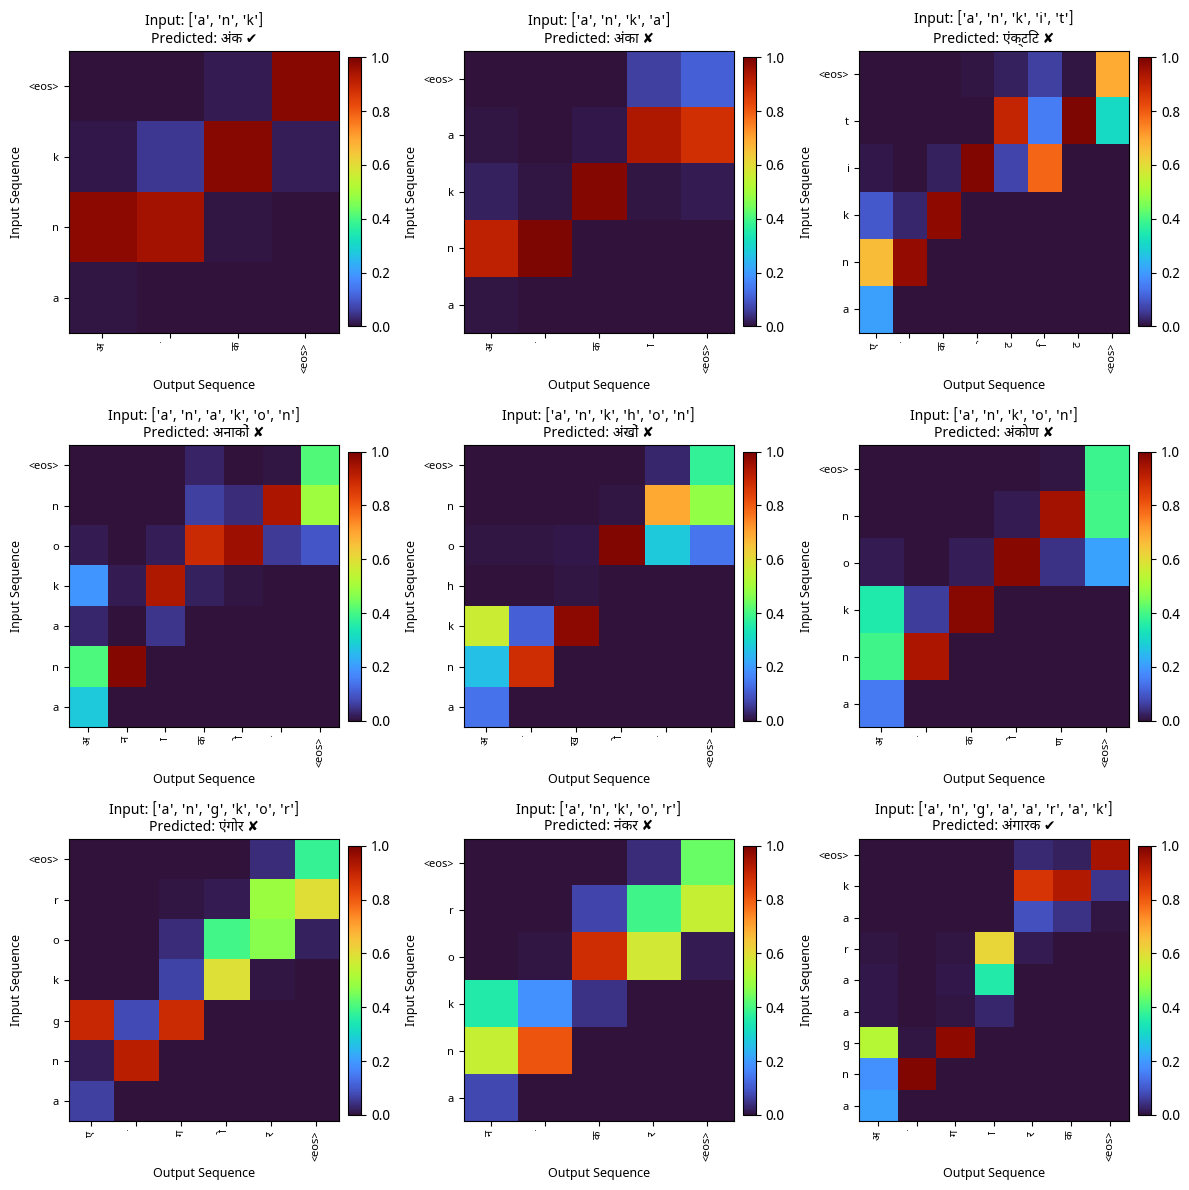

saved predictions_attention/attention_grid_batch2.png


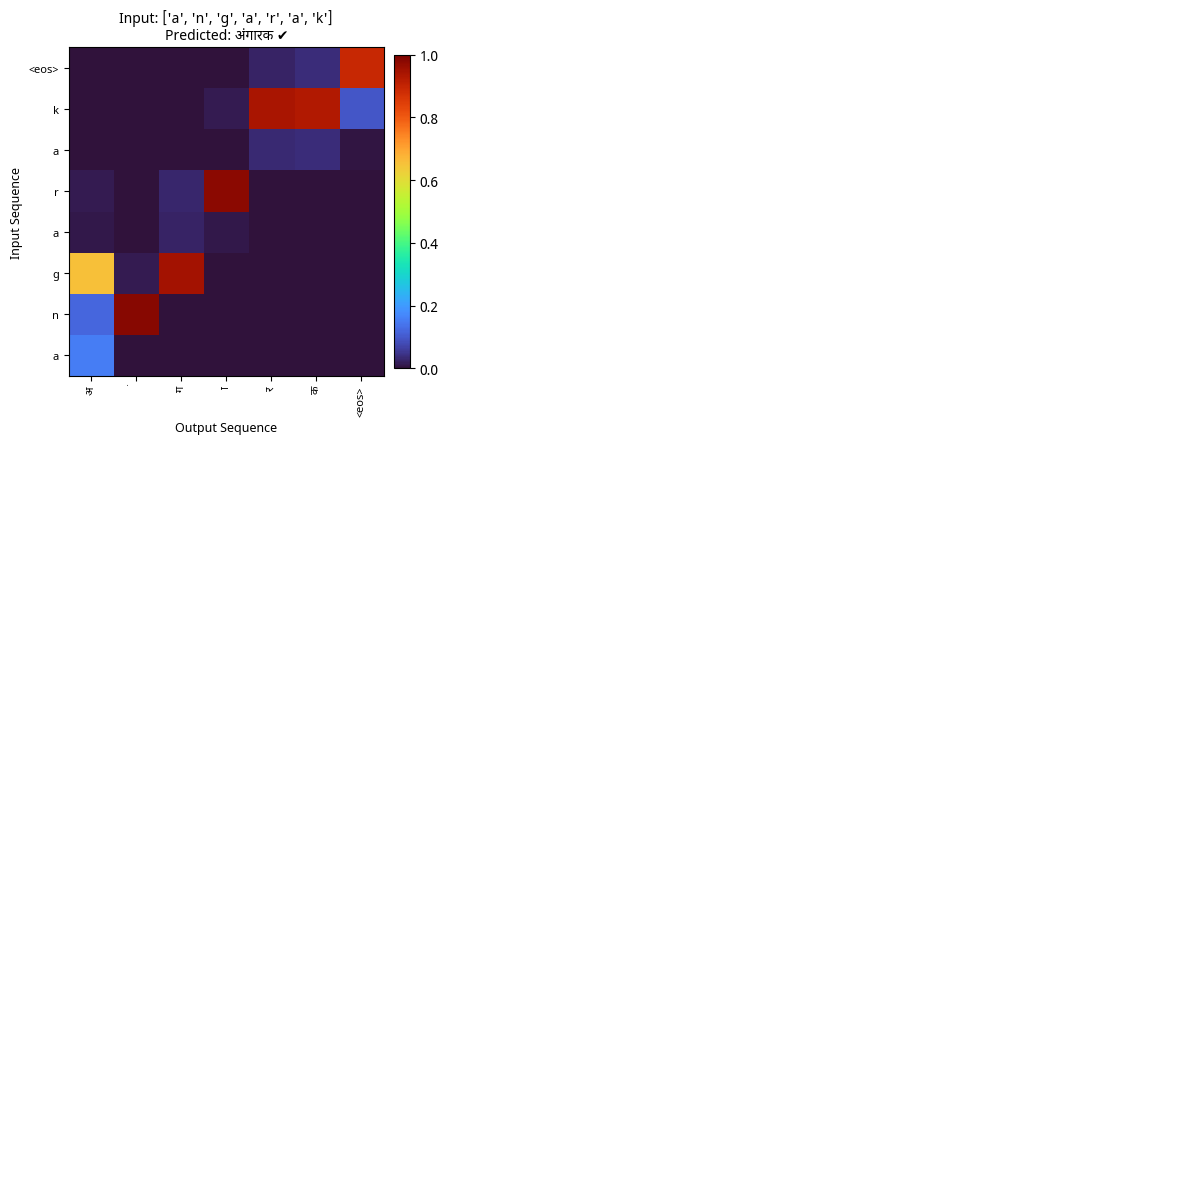

In [14]:


# --- device fallback in case you restarted the kernel ----------
try:
    DEVICE
except NameError:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SOS, EOS, PAD = t2i["<sos>"], t2i["<eos>"], t2i["<pad>"]


#  decode ONE word & capture its attention matrix

def _decode_with_attention(word: str, max_len=50):
    src_ids = [SOS] + [s2i.get(c, s2i["<unk>"]) for c in word] + [EOS]
    src     = torch.tensor(src_ids, device=DEVICE).unsqueeze(0)  
    mask    = src != PAD

    with torch.no_grad():
        enc_out, enc_h = model.encoder(model.src_emb(src))
        dec_h = model._init_dec_state(enc_h)

    src_chars  = list(word) + ["<eos>"]
    out_chars  = []
    rows = []
    inp = torch.tensor([SOS], device=DEVICE)

    for _ in range(max_len):
        emb = model.tgt_emb(inp).unsqueeze(1)                     
        last_h = dec_h[0][-1] if BEST_CFG["cell_type"] == "LSTM" else dec_h[-1]
        ctx, attn = model.attn(last_h, enc_out, mask)            
        rows.append(attn.squeeze(0).detach().cpu().numpy())              

        
        dec_in = torch.cat([emb, ctx.unsqueeze(1)], 2)
        with torch.no_grad():
            dec_out, dec_h = model.decoder(dec_in, dec_h)

        nxt = model.fc_out(dec_out.squeeze(1)).argmax(1)
        if nxt.item() == EOS:
            break
        out_chars.append(i2t[nxt.item()])
        inp = nxt

    A = np.stack(rows)                                         
    return "".join(out_chars), src_chars, A



#  draw a 3×3 grid of heat-maps

def plot_attention_grid(model,test_pairs,n_examples: int = 9,save_path: str | None = "predictions_attention/attention_grid.png", cmap: str = "viridis"):
    # n_examples  total examples to show (first N from test_pairs)
    
    rows = cols = 3
    per_fig = rows * cols
    n_figs  = ceil(n_examples / per_fig)
    sample  = test_pairs[:n_examples]

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    for f in range(n_figs):
        fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
        axes = axes.flatten()

        for k, ax in enumerate(axes):
            idx = f * per_fig + k
            if idx >= n_examples:
                ax.axis("off")
                continue

            latin, gold = sample[idx]
            pred, src_chars, A_full = _decode_with_attention(latin)

            # crop: drop <sos> column and pad beyond src_chars
            S_true = len(src_chars) + 1           # incl <sos> we dropped
            A = A_full[:, 1:S_true]               # [T_out, len(src_chars)]

            # plot rows=input, cols=output  ->  transpose
            im = ax.imshow(A.T,
                           origin='lower',
                           aspect='auto',
                           vmin=0, vmax=1,
                           cmap=cmap)

            # ticks
            ax.set_yticks(range(len(src_chars)))
            ax.set_yticklabels(src_chars, fontsize=8)
            dst_chars = list(pred) + ["<eos>"]
            ax.set_xticks(range(len(dst_chars)))
            ax.set_xticklabels(dst_chars, rotation=90, fontsize=8)

            ax.set_ylabel("Input Sequence",  fontsize=9)
            ax.set_xlabel("Output Sequence", fontsize=9)

            status = "✔" if pred == gold else "✘"
            ax.set_title(f"Input: {repr(src_chars[:-1])}\nPredicted: {pred} {status}",
                         fontsize=10)

            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.03)

        plt.tight_layout()
        if save_path:
            base, ext = os.path.splitext(save_path)
            fname = f"{base}_batch{f+1}{ext}"
            fig.savefig(fname, dpi=300, bbox_inches="tight")
            print(f"saved {fname}")
        plt.show()



font_path = Path("/kaggle/input/hindi-scipt/NotoSansDevanagari-VariableFont_wdth,wght.ttf")
fm.fontManager.addfont(str(font_path))         # add to Matplotlib’s cache
#plt.rcParams["font.family"] = "Noto Sans Devanagari"    
plt.rcParams["font.family"] = ["Noto Sans Devanagari", "DejaVu Sans"]

plot_attention_grid(model,test_pairs,n_examples=10,save_path="predictions_attention/attention_grid.png",cmap="turbo")       


# Question 6:

In [36]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Path to your font file (as seen in your Kaggle input)
font_path = "/kaggle/input/hindi-scipt/NotoSansDevanagari-VariableFont_wdth,wght.ttf"

# Load font
font_prop = fm.FontProperties(fname=font_path)

# Set it as default font for text rendering
plt.rcParams['font.family'] = font_prop.get_name()


In [40]:
def visualize_attention_lines(model, word, s2i, t2i, i2t, device):
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm

    # Load font again here (safe even if run in different cells)
    font_path = "/kaggle/input/hindi-scipt/NotoSansDevanagari-VariableFont_wdth,wght.ttf"
    font_prop = fm.FontProperties(fname=font_path)

    model.eval()

    chars_in = ['<sos>'] + list(word) + ['<eos>']
    input_indices = [s2i.get(ch, s2i["<unk>"]) for ch in chars_in]
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)
    input_len = torch.tensor([len(input_indices)]).to(device)

    with torch.no_grad():
        enc_outs, enc_hid = model.encoder(model.src_emb(input_tensor))
        dec_hid = model._init_dec_state(enc_hid)
        mask = (input_tensor != s2i["<pad>"])

    tgt_input = torch.tensor([t2i["<sos>"]], device=device)
    attn_map, decoded_output = [], []

    for _ in range(50):
        last_state = dec_hid[0][-1] if isinstance(dec_hid, tuple) else dec_hid[-1]
        ctx, attn = model.attn(last_state, enc_outs, mask)
        attn_map.append(attn.squeeze(0).cpu().detach().numpy())

        embed = model.tgt_emb(tgt_input).unsqueeze(1)
        rnn_input = torch.cat((embed, ctx.unsqueeze(1)), dim=2)
        rnn_output, dec_hid = model.decoder(rnn_input, dec_hid)

        combined = model.fc_out(rnn_output.squeeze(1))
        next_idx = combined.argmax(1).item()

        decoded_output.append(i2t[next_idx])
        if decoded_output[-1] == "<eos>":
            break
        tgt_input = torch.tensor([next_idx], device=device)

    # Plot attention lines with Devanagari font
    fig, ax = plt.subplots(figsize=(10, 5))

    for i, ch in enumerate(chars_in):
        ax.text(i, 1.05, ch, ha='center', fontsize=9, fontproperties=font_prop)

    for i, ch in enumerate(decoded_output):
        ax.text(i, -0.05, ch, ha='center', fontsize=9, fontproperties=font_prop)

    for i, attn in enumerate(attn_map):
        src_index = attn.argmax()
        ax.plot([src_index, i], [1, 0], color='gray', alpha=0.6)

    ax.set_title("Attention Connectivity", fontproperties=font_prop)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


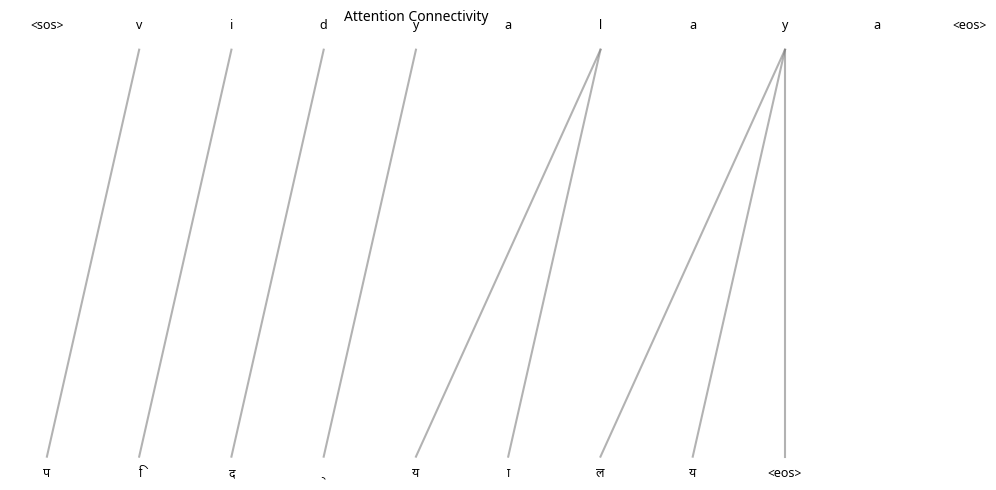

In [41]:
# Example word to visualize
input_word = "vidyalaya"

# Call visualization
visualize_attention_lines(
    model=model,
    word=input_word,
    s2i=s2i,
    t2i=t2i,
    i2t=i2t,
    device=DEVICE
)


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2342 (\N{DEVANAGARI LETTER DA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2351 (\N{DEVANAGARI LETTER YA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn

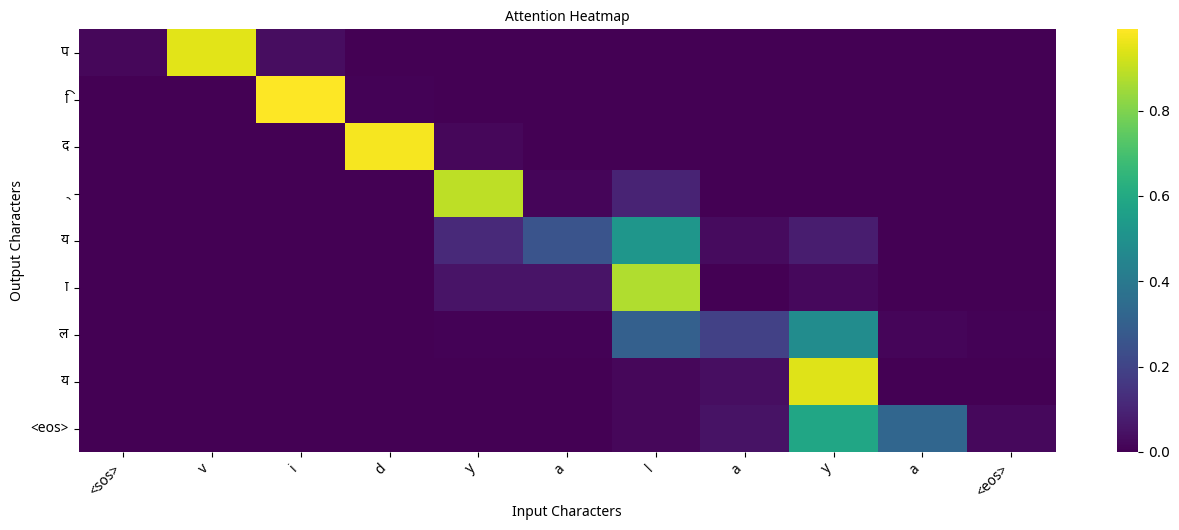

In [43]:
input_word = "vidyalaya"  # or try other examples like "shakti", "ankganit", "kranti"

plot_att_map(
    model=model,
    word=input_word,
    s2i=s2i,
    t2i=t2i,
    i2t=i2t,
    device=DEVICE
)


In [44]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import torch

def plot_topk_attention_lines(model, word, s2i, t2i, i2t, device, top_k=2):
    # Load Devanagari font
    font_path = "/kaggle/input/hindi-scipt/NotoSansDevanagari-VariableFont_wdth,wght.ttf"
    font_prop = fm.FontProperties(fname=font_path)

    model.eval()

    chars_in = ['<sos>'] + list(word) + ['<eos>']
    input_ids = [s2i.get(ch, s2i["<unk>"]) for ch in chars_in]
    src_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)
    mask = (src_tensor != s2i["<pad>"])

    with torch.no_grad():
        enc_outs, enc_hid = model.encoder(model.src_emb(src_tensor))
        dec_hid = model._init_dec_state(enc_hid)

    tgt_input = torch.tensor([t2i["<sos>"]], device=device)
    attention_links = []
    output_chars = []

    for _ in range(50):
        last = dec_hid[0][-1] if isinstance(dec_hid, tuple) else dec_hid[-1]
        ctx, attn = model.attn(last, enc_outs, mask)
        attn = attn.squeeze(0).cpu().detach().numpy()
        topk_indices = attn.argsort()[-top_k:][::-1]
        attention_links.append(topk_indices)

        emb = model.tgt_emb(tgt_input).unsqueeze(1)
        rnn_input = torch.cat((emb, ctx.unsqueeze(1)), dim=2)
        dec_output, dec_hid = model.decoder(rnn_input, dec_hid)
        logits = model.fc_out(dec_output.squeeze(1))
        pred_id = logits.argmax(1).item()
        output_char = i2t[pred_id]
        output_chars.append(output_char)
        if output_char == "<eos>":
            break
        tgt_input = torch.tensor([pred_id], device=device)

    # Plot top-k lines
    fig, ax = plt.subplots(figsize=(10, 5))
    for i, ch in enumerate(chars_in):
        ax.text(i, 1.05, ch, ha='center', fontproperties=font_prop)
    for i, ch in enumerate(output_chars):
        ax.text(i, -0.05, ch, ha='center', fontproperties=font_prop)

    for out_idx, topk_src in enumerate(attention_links):
        for src_idx in topk_src:
            ax.plot([src_idx, out_idx], [1, 0], color='gray', alpha=0.5)

    ax.set_title(f"Top-{top_k} Attention Lines", fontproperties=font_prop)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


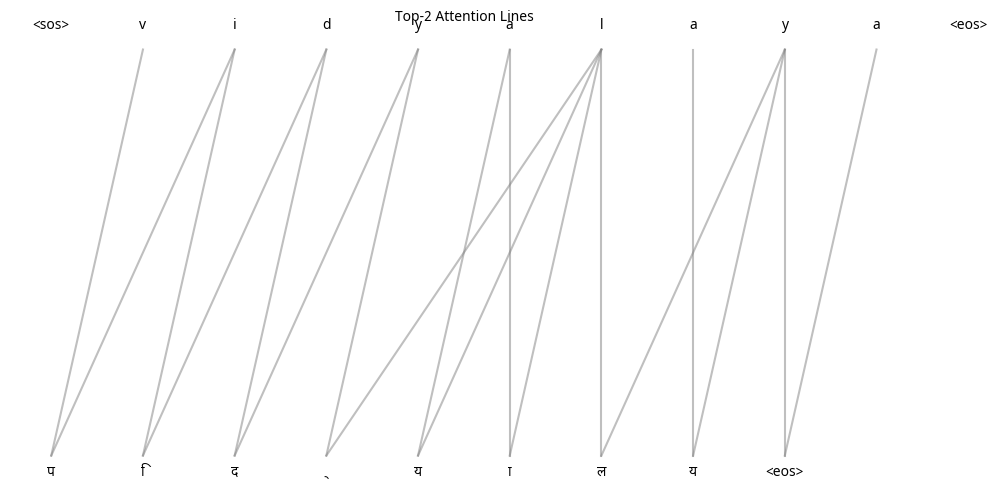

In [45]:
plot_topk_attention_lines(model, word="vidyalaya", s2i=s2i, t2i=t2i, i2t=i2t, device=DEVICE, top_k=2)


In [46]:
from IPython.display import HTML, display

def attention_tile_html(attn, input_chars, out_char, font_path):
    bars = []
    for i, weight in enumerate(attn):
        bar = f"""
            <div style="margin:2px;">
                <div style="font-size:12px; font-family: '{font_path}';">{input_chars[i]}</div>
                <div style="width:{weight*100:.1f}%; background-color:#4a90e2; height:6px;"></div>
            </div>
        """
        bars.append(bar)

    return f"""
        <div style="padding:10px; border:1px solid #ccc; border-radius:6px; width:80px; font-family:'{font_path}';">
            <div style="text-align:center; font-weight:bold; font-size:14px;">{out_char}</div>
            {''.join(bars)}
        </div>
    """

def show_attention_tiles(model, word, s2i, t2i, i2t, device):
    font_path = "/kaggle/input/hindi-scipt/NotoSansDevanagari-VariableFont_wdth,wght.ttf"

    model.eval()
    input_chars = ['<sos>'] + list(word) + ['<eos>']
    input_ids = [s2i.get(ch, s2i["<unk>"]) for ch in input_chars]
    src_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)
    mask = (src_tensor != s2i["<pad>"])

    with torch.no_grad():
        enc_outs, enc_hid = model.encoder(model.src_emb(src_tensor))
        dec_hid = model._init_dec_state(enc_hid)

    tgt_input = torch.tensor([t2i["<sos>"]], device=device)
    html_blocks = []

    for _ in range(50):
        last = dec_hid[0][-1] if isinstance(dec_hid, tuple) else dec_hid[-1]
        ctx, attn = model.attn(last, enc_outs, mask)
        attn = attn.squeeze(0).cpu().detach().numpy()

        emb = model.tgt_emb(tgt_input).unsqueeze(1)
        rnn_input = torch.cat((emb, ctx.unsqueeze(1)), dim=2)
        dec_output, dec_hid = model.decoder(rnn_input, dec_hid)
        pred_logits = model.fc_out(dec_output.squeeze(1))
        pred_id = pred_logits.argmax(1).item()
        output_char = i2t[pred_id]

        html = attention_tile_html(attn, input_chars, output_char, font_path)
        html_blocks.append(html)

        if output_char == "<eos>":
            break
        tgt_input = torch.tensor([pred_id], device=device)

    display(HTML(f"<div style='display:flex; gap:10px;'>{''.join(html_blocks)}</div>"))


In [47]:
show_attention_tiles(model, word="vidyalaya", s2i=s2i, t2i=t2i, i2t=i2t, device=DEVICE)
